The idea is to use a larger training data set with 320x240 pixels and see how we can upscale the model to a more meaningful size. Can we crack the performance of the 92x72 by using higher resolution? Or might it be a better route to put an SR model on top of the 92x72 model?

In [2]:
%matplotlib inline

from importlib import reload
import DL_utils.utils2 as utils2; reload(utils2)
from DL_utils.utils2 import *
import DL_utils.dl as dl; reload(dl) #  makes sure dl is always reloaded when changed\n",
from DL_utils.dl import * # access all imports of dl"

import DL_utils.clr_callback as clr; reload(clr)# Cyclical learning rate annealing
from DL_utils.clr_callback import *

import segm_utils.su as su; reload(su)
from segm_utils.su import *

import DenseNet.densenet as dn; reload(dn)
import SemSeg_DN.densenet_fc as ssdn; reload(ssdn)
from SemSeg_DN.densenet_fc import *

import DL_utils.bcolz_array_iterator as bc; reload(bc)
from DL_utils.bcolz_array_iterator import *

import DL_utils.vgg16 as vgg; reload(vgg)
from DL_utils.vgg16 import *

import cv2

from tqdm import tqdm, tqdm_notebook

Using TensorFlow backend.
/home/zwerg/anaconda3/envs/py3TF/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/zwerg/anaconda3/envs/py3TF/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
WORKDIR = './'

BCOLZ_TRN = WORKDIR+'bcolz/train'
BCOLZ_VAL = WORKDIR+'bcolz/validation'
BCOLZ_TRN_LBL = WORKDIR+'bcolz/train_labels/'
BCOLZ_TRN_LBL_CONV = WORKDIR+'bcolz/train_labels_conv/'
BCOLZ_VAL_LBL = WORKDIR+'bcolz/validation_labels/'
BCOLZ_VAL_LBL_CONV = WORKDIR+'bcolz/validation_labels_conv/'
BCOLZ_TEST = WORKDIR+'bcolz/test/'
BCOLZ_TEST_LBL = WORKDIR+'bcolz/test_labels/'
BCOLZ_TEST_LBL_CONV = WORKDIR+'bcolz/test_labels_conv/'

CAMVID_IMGS = WORKDIR+'701_StillsRaw_full/' 
CAMVID_LBLS = WORKDIR+'LabeledApproved_full/'

CAMVID_COLORS = WORKDIR+'label_colors.txt' # assigns RGB values to classes

RESULTS = WORKDIR+'results/'

BATCH_SIZE = 6
IMAGE_SIZE = (320,240)

NB_CLASSES = 33

#MEAN = np.array([ 114.8054804,   111.46616081,  102.09720663]) # Mean across all train and test images in PIL byte order
#STD = np.array([ 0.37066581,  0.25355653,  0.25101855]) # standard deviation ditto

TF_BOARD = WORKDIR+'tf_board/'

SEED = np.random.randint(46)

In [4]:
X_trn = bcolz.open(BCOLZ_TRN)
y_trn = bcolz.open(BCOLZ_TRN_LBL)
y_trn_conv = bcolz.open(BCOLZ_TRN_LBL_CONV)
X_val = bcolz.open(BCOLZ_VAL)
y_val = bcolz.open(BCOLZ_VAL_LBL)
y_val_conv = bcolz.open(BCOLZ_VAL_LBL_CONV)
X_test = bcolz.open(BCOLZ_TEST)
y_test = bcolz.open(BCOLZ_TEST_LBL)
y_test_conv = bcolz.open(BCOLZ_TEST_LBL_CONV)

In [4]:
crop_sz = (64, 64)

In [5]:
trn_gen = segm_generator_hd(X_trn, y_trn_conv, 1, crop_sz, train=True)
val_gen = segm_generator_hd(X_val, y_val_conv, 1, crop_sz, train=False)
test_gen = segm_generator_hd(X_test, y_test_conv, 1, crop_sz, train=False)

In [19]:
def Tiramisu(nb_classes, input_size, nb_dense_block=6, 
    growth_rate=16, nb_filter=48, nb_layers_per_block=5, p=None, wd=0):
    img_input = Input(input_size)
    output = create_tiramisu_hd(nb_classes, img_input, nb_dense_block, growth_rate, nb_filter, nb_layers_per_block, p, wd)
    return Model(img_input, output)


In [7]:
nb_layers_per_block=[4,5,7,10,12,15]

In [8]:
model = Tiramisu(NB_CLASSES, crop_sz+(3,), 6, 16, 48, nb_layers_per_block, p=0.1, wd=1e-4)

trans_dn [None, 64, 64, 112]
trans_dn [None, 32, 32, 192]
trans_dn [None, 16, 16, 304]
trans_dn [None, 8, 8, 464]
trans_dn [None, 4, 4, 656]
trans_dn [None, 2, 2, 896]
up_path_before
up_path_transition_up
x: Tensor("add_121:0", shape=(?, ?, ?, 240), dtype=float32)
up_path_before
x: Tensor("concat_66:0", shape=(?, 4, 4, 1088), dtype=float32)
up_path_transition_up
x: Tensor("add_147:0", shape=(?, ?, ?, 192), dtype=float32)
up_path_before
x: Tensor("concat_78:0", shape=(?, 8, 8, 816), dtype=float32)
up_path_transition_up
x: Tensor("add_169:0", shape=(?, ?, ?, 160), dtype=float32)
up_path_before
x: Tensor("concat_87:0", shape=(?, 16, 16, 576), dtype=float32)
up_path_transition_up
x: Tensor("add_185:0", shape=(?, ?, ?, 112), dtype=float32)
up_path_before
x: Tensor("concat_94:0", shape=(?, 32, 32, 384), dtype=float32)
up_path_transition_up
x: Tensor("add_197:0", shape=(?, ?, ?, 80), dtype=float32)


In [9]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 64, 64, 3)     0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 64, 48)    1344        input_1[0][0]                    
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 64, 64, 48)    192         convolution2d_1[0][0]            
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 64, 64, 48)    0           batchnormalization_1[0][0]       
___________________________________________________________________________________________

In [10]:
model.compile(RMSprop(1e-3), 'sparse_categorical_crossentropy', ['accuracy'])

In [219]:
checkpointer = ModelCheckpoint(filepath="./results/"+timestamp()+"_camvid_tiramisu_320_240_{epoch:02d}_{val_acc:.2f}.h5", 
                               verbose=0, save_best_only=True, monitor = 'val_acc')

In [12]:
samples = len(X_trn)

In [13]:
val_samples = len(X_val);print(val_samples)

101


In [14]:
a, b = next(trn_gen)

In [15]:
print(a.shape); print(b.shape)

(1, 64, 64, 3)
(1, 64, 64, 1)


In [16]:
model.fit_generator(trn_gen, 3*samples, 1, 0, callbacks=[checkpointer], 
                    validation_data=val_gen, nb_val_samples=val_samples, nb_worker=4)

In [17]:
model.fit_generator(trn_gen, 3*samples, 130, 2, callbacks=[checkpointer], 
                    validation_data=val_gen, nb_val_samples=val_samples, nb_worker=4)

Epoch 1/130
124s - loss: 1.6496 - acc: 0.5519 - val_loss: 0.8335 - val_acc: 0.8227
Epoch 2/130
124s - loss: 1.5296 - acc: 0.5685 - val_loss: 0.7636 - val_acc: 0.8241
Epoch 3/130
124s - loss: 1.4915 - acc: 0.5788 - val_loss: 0.9127 - val_acc: 0.7756
Epoch 4/130
124s - loss: 1.4104 - acc: 0.6080 - val_loss: 1.0965 - val_acc: 0.7508
Epoch 5/130
124s - loss: 1.3601 - acc: 0.6356 - val_loss: 2.0368 - val_acc: 0.5420
Epoch 6/130
125s - loss: 1.3385 - acc: 0.6535 - val_loss: 0.7760 - val_acc: 0.8315
Epoch 7/130
125s - loss: 1.2710 - acc: 0.6818 - val_loss: 0.7825 - val_acc: 0.8336
Epoch 8/130
124s - loss: 1.2508 - acc: 0.6870 - val_loss: 0.8454 - val_acc: 0.8060
Epoch 9/130
124s - loss: 1.2342 - acc: 0.6956 - val_loss: 0.8902 - val_acc: 0.7910
Epoch 10/130
124s - loss: 1.2163 - acc: 0.7064 - val_loss: 0.8830 - val_acc: 0.8019
Epoch 11/130
124s - loss: 1.1928 - acc: 0.7131 - val_loss: 0.8938 - val_acc: 0.8254
Epoch 12/130
124s - loss: 1.1928 - acc: 0.7172 - val_loss: 0.8758 - val_acc: 0.7975
E

In [18]:
out = model.predict_generator(trn_gen, 1, nb_worker=4)

In [19]:
out.shape

(1, 64, 64, 33)

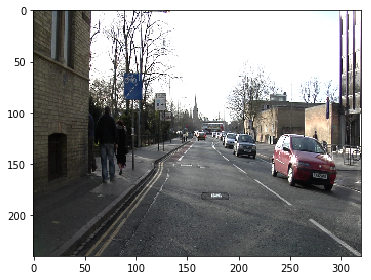

In [5]:
show(X_trn[150])

In [13]:
y_trn_conv.shape

(367, 240, 320)

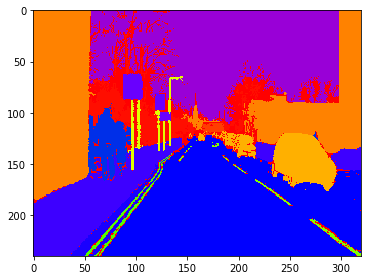

In [14]:
show(y_trn_conv[150], do_deprocess=False, cmap='prism')

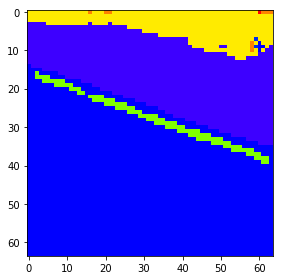

In [20]:
show(out[0].argmax(axis=-1), do_deprocess=False, cmap='prism')

In [21]:
save_model(model, './results/', 'camvid_tiramisu_320_240_epoch131')

2017-05-03-12:18
camvid_tiramisu_320_240_epoch131
Saved  model  to  disk


In [22]:
model.fit_generator(trn_gen, 3*samples, 240, 2, callbacks=[checkpointer], 
                    validation_data=val_gen, nb_val_samples=val_samples, nb_worker=4)

Epoch 1/240
120s - loss: 1.5892 - acc: 0.7656 - val_loss: 1.5418 - val_acc: 0.7841
Epoch 2/240
119s - loss: 1.5431 - acc: 0.7795 - val_loss: 1.3206 - val_acc: 0.8540
Epoch 3/240
120s - loss: 1.5576 - acc: 0.7759 - val_loss: 1.3973 - val_acc: 0.8228
Epoch 4/240
120s - loss: 1.5734 - acc: 0.7742 - val_loss: 1.3982 - val_acc: 0.8500
Epoch 5/240
119s - loss: 1.5274 - acc: 0.7844 - val_loss: 1.5133 - val_acc: 0.8171
Epoch 6/240
120s - loss: 1.5676 - acc: 0.7786 - val_loss: 1.4545 - val_acc: 0.8395
Epoch 7/240
119s - loss: 1.4964 - acc: 0.7925 - val_loss: 1.4362 - val_acc: 0.8462
Epoch 8/240
120s - loss: 1.5629 - acc: 0.7788 - val_loss: 1.4497 - val_acc: 0.8273
Epoch 9/240
120s - loss: 1.5925 - acc: 0.7707 - val_loss: 1.5004 - val_acc: 0.8084
Epoch 10/240
120s - loss: 1.5517 - acc: 0.7866 - val_loss: 1.3868 - val_acc: 0.8192
Epoch 11/240
120s - loss: 1.5653 - acc: 0.7777 - val_loss: 1.4447 - val_acc: 0.8547
Epoch 12/240
120s - loss: 1.5831 - acc: 0.7705 - val_loss: 1.3488 - val_acc: 0.8401
E

KeyboardInterrupt: 

This isn't going anywhere. The model levels out again at 0.77 acc. Earlier, when using 96x72 pixel the model accuracy would go up much more quickly. I am wondering if the 64x64 crops are too small in relation to the 320x240 images (only about 1/25th of the total area is covered) then maybe context is missing. The importance of spatial context is hinted at by the fact that the 92x76 model trained faster when fed with matrix labels instead of unrolled, vectorized labels. So, maybe the crop needs to be made bigger. 
One option would be to extend this trained model wiht a new input and output and finetune those new layers, while keeping the others constant. However, it might be quicker to build a new model with higher rez and train it for about 20 epochs or so. It should then have higher accuracy than this 64x64 model after 20 epochs, i.e. acc > 0.72. If so, it might be worth retraining the new model. Even though at 192x192 px one epoch will take about 12 min to train this might still be faster than messing around with the existing underperforming model. 

In [34]:
crop_sz = (192, 192)

In [35]:
trn_gen_192 = segm_generator_hd(X_trn, y_trn_conv, 1, crop_sz, train=True)
val_gen_192 = segm_generator_hd(X_val, y_val_conv, 1, crop_sz, train=False)
test_gen_192 = segm_generator_hd(X_test, y_test_conv, 1, crop_sz, train=False)

In [24]:
def Tiramisu(nb_classes, input_size, nb_dense_block=6, 
    growth_rate=16, nb_filter=48, nb_layers_per_block=5, p=None, wd=0):
    img_input = Input(input_size)
    output = create_tiramisu_hd(nb_classes, img_input, nb_dense_block, growth_rate, nb_filter, nb_layers_per_block, p, wd)
    return Model(img_input, output)


In [25]:
nb_layers_per_block=[4,5,7,10,12,15]

In [29]:
model_192 = Tiramisu(NB_CLASSES, crop_sz+(3,), 6, 16, 48, nb_layers_per_block, p=0.1, wd=1e-4)

trans_dn [None, 192, 192, 112]
trans_dn [None, 96, 96, 192]
trans_dn [None, 48, 48, 304]
trans_dn [None, 24, 24, 464]
trans_dn [None, 12, 12, 656]
trans_dn [None, 6, 6, 896]
up_path_before
up_path_transition_up
x: Tensor("add_1436:0", shape=(?, ?, ?, 240), dtype=float32)
up_path_before
x: Tensor("concat_268:0", shape=(?, 12, 12, 1088), dtype=float32)
up_path_transition_up
x: Tensor("add_1462:0", shape=(?, ?, ?, 192), dtype=float32)
up_path_before
x: Tensor("concat_280:0", shape=(?, 24, 24, 816), dtype=float32)
up_path_transition_up
x: Tensor("add_1484:0", shape=(?, ?, ?, 160), dtype=float32)
up_path_before
x: Tensor("concat_289:0", shape=(?, 48, 48, 576), dtype=float32)
up_path_transition_up
x: Tensor("add_1500:0", shape=(?, ?, ?, 112), dtype=float32)
up_path_before
x: Tensor("concat_296:0", shape=(?, 96, 96, 384), dtype=float32)
up_path_transition_up
x: Tensor("add_1512:0", shape=(?, ?, ?, 80), dtype=float32)


In [30]:
model_192.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 192, 192, 3)   0                                            
____________________________________________________________________________________________________
convolution2d_199 (Convolution2D (None, 192, 192, 48)  1344        input_3[0][0]                    
____________________________________________________________________________________________________
batchnormalization_195 (BatchNor (None, 192, 192, 48)  192         convolution2d_199[0][0]          
____________________________________________________________________________________________________
activation_197 (Activation)      (None, 192, 192, 48)  0           batchnormalization_195[0][0]     
___________________________________________________________________________________________

In [32]:
model_192.compile(RMSprop(1e-3), 'sparse_categorical_crossentropy', ['accuracy'])

Let's accelerate the test by using fewer samples.

In [36]:
model_192.fit_generator(trn_gen_192, samples, 20, 0,  
                    validation_data=val_gen_192, nb_val_samples=val_samples, nb_worker=4)

In [37]:
save_model(model_192, './results/', 'camvid_tiramisu_192_epoch20')

2017-05-03-13:38
camvid_tiramisu_192_epoch20
Saved  model  to  disk


In [38]:
model_192.fit_generator(trn_gen_192, samples, 40, 0,  
                    validation_data=val_gen_192, nb_val_samples=val_samples, nb_worker=4)

In [39]:
save_model(model_192, './results/', 'camvid_tiramisu_192_epoch60')

2017-05-03-14:38
camvid_tiramisu_192_epoch60
Saved  model  to  disk


In [40]:
model_192.fit_generator(trn_gen_192, samples, 100, 0,  
                    validation_data=val_gen_192, nb_val_samples=val_samples, nb_worker=4)

In [41]:
save_model(model_192, './results/', 'camvid_tiramisu_192_epoch160')

2017-05-03-20:45
camvid_tiramisu_192_epoch160
Saved  model  to  disk


In [43]:
out = model_192.predict_generator(trn_gen_192, 1, nb_worker=4)

In [44]:
out.shape

(1, 192, 192, 33)

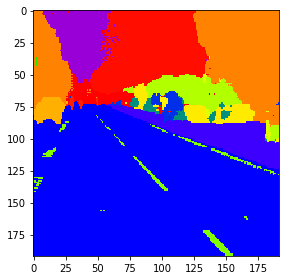

In [45]:
show(out[0].argmax(axis=-1), do_deprocess=False, cmap='prism')

In [47]:
out = model_192.predict_generator(trn_gen_192, 25, nb_worker=4)

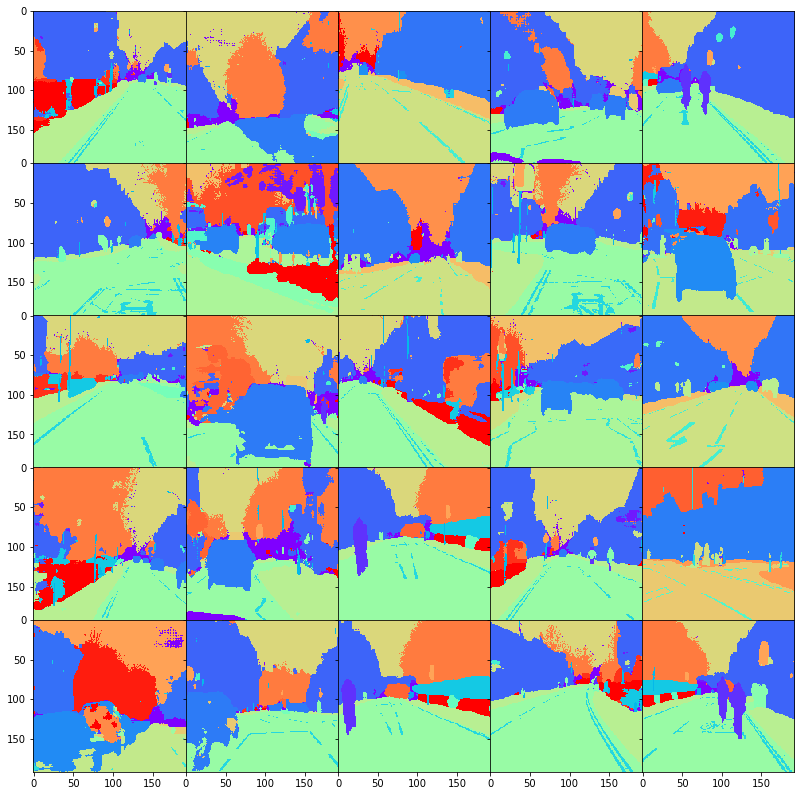

In [54]:
plotGrid(out[0:25].argmax(axis=-1), (14., 14.), cmap='rainbow')

In [52]:
to_plot(out[3], (192, 192)).shape

(33, 192, 192)

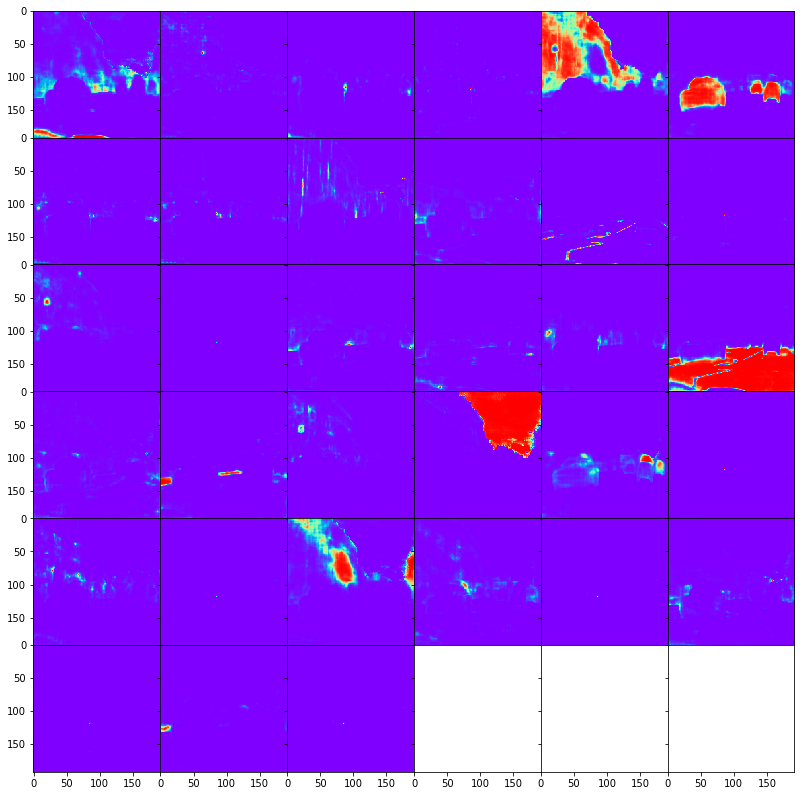

In [53]:
plotGrid(to_plot(out[3], (192, 192)), (14., 14.), cmap='rainbow')

In [59]:
print(len(X_trn)); print(len(X_val)); print(len(X_test))

367
101
233


In [57]:
loss_trn, acc_trn = model_192.evaluate_generator(trn_gen_192, 367, nb_worker=4)

In [58]:
print(loss_trn, acc_trn)

0.509269290951 0.884957675388


In [60]:
loss_val, acc_val = model_192.evaluate_generator(val_gen_192, 101, nb_worker=4)

In [62]:
print(loss_val, acc_val)

0.553381563708 0.877068582148


In [61]:
loss_test, acc_test = model_192.evaluate_generator(test_gen_192, 233, nb_worker=4)

In [63]:
print(loss_test, acc_test)

0.562985471134 0.874932204833


Wow, not bad at all! Both visually and numerically convincing. So, the context DOES matter, quite a lot. A few more rounds of training with lower lr to finetune.

In [138]:
def full_size_predictor(model, src_img_array, crop_size, nb_classes):
    assert len(src_img_array.shape) == 4
    assert len(crop_size) == 2
    nb_imgs, rows, cols, ch = src_img_array.shape
    crop_rows, crop_cols = [*crop_size]
    pad_rows = (crop_rows-(rows % crop_rows))#(rows + (crop_rows-(rows % crop_rows)))/crop_rows
    pad_cols = (crop_cols-(cols % crop_cols))#(cols + (crop_cols-(cols % crop_cols)))/crop_cols
    range_rows = int((rows + pad_rows)/crop_rows)
    range_cols = int((cols + pad_cols)/crop_cols)
    output_imgs = np.zeros((nb_imgs, rows, cols, nb_classes))
    #output_imgs = np.zeros((nb_imgs, rows, cols, ch))
    preds = np.zeros((rows+pad_rows, cols+pad_cols, nb_classes))
    #preds = np.zeros((rows+pad_rows, cols+pad_cols, ch))
    for i in tqdm_notebook(range(nb_imgs)):
        input_img = cv2.copyMakeBorder(src_img_array[i], top = 0,
                              bottom = pad_rows, 
                              left = 0, 
                              right = pad_cols, 
                              borderType = cv2.BORDER_REFLECT_101)
        input_img = np.expand_dims(input_img, axis=0)
        for r in range(range_rows):
            for c in range(range_cols):
                #print(r, c)
                r_slice = slice(r*crop_rows, (r+1)*crop_rows)
                c_slice = slice(c*crop_cols, (c+1)*crop_cols)
                #print(r_slice); print(c_slice)
                preds[r_slice, c_slice, :] = model.predict(input_img[:, r_slice, c_slice], 1)
                #preds[r_slice, c_slice, :] = input_img[:, r_slice, c_slice]
                #print(preds.shape)
        output_imgs[i] = preds[:rows, :cols, :]
    print(len(output_imgs))
    return np.stack(output_imgs)

In [ ]:
np.append()

In [112]:
np.zeros((0, 3, 4, ))

array([], shape=(0, 3, 4), dtype=float64)

In [139]:
oi = full_size_predictor(model_192, X_trn[0:4], (192, 192), NB_CLASSES)


4


In [140]:
oi.shape

(4, 240, 320, 33)

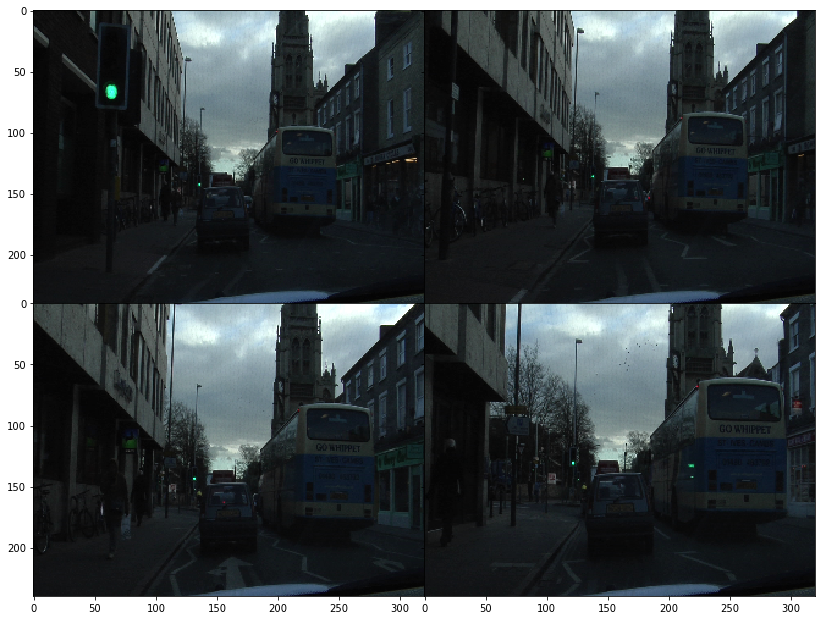

In [137]:
plotGrid(oi, (14., 14.))

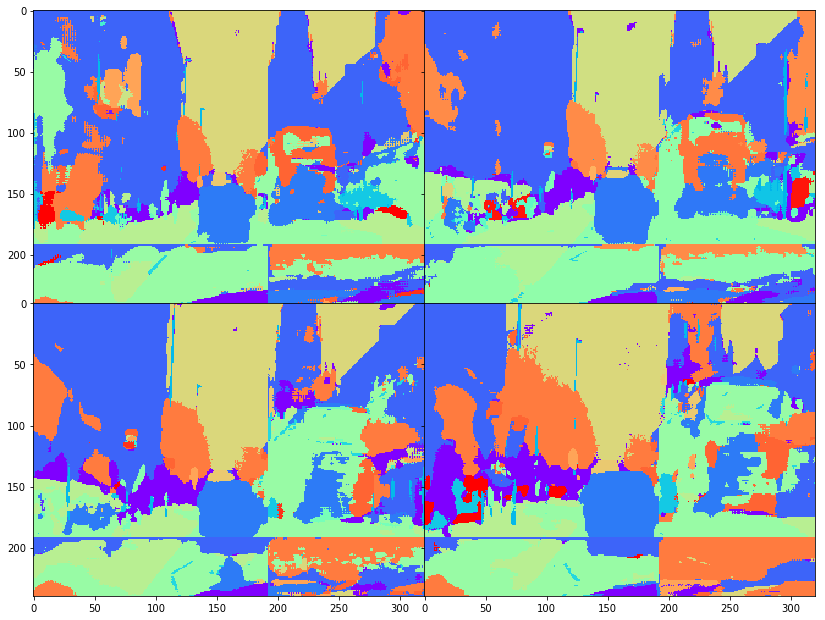

In [141]:
plotGrid(oi.argmax(axis=-1), (14., 14.), cmap='rainbow')

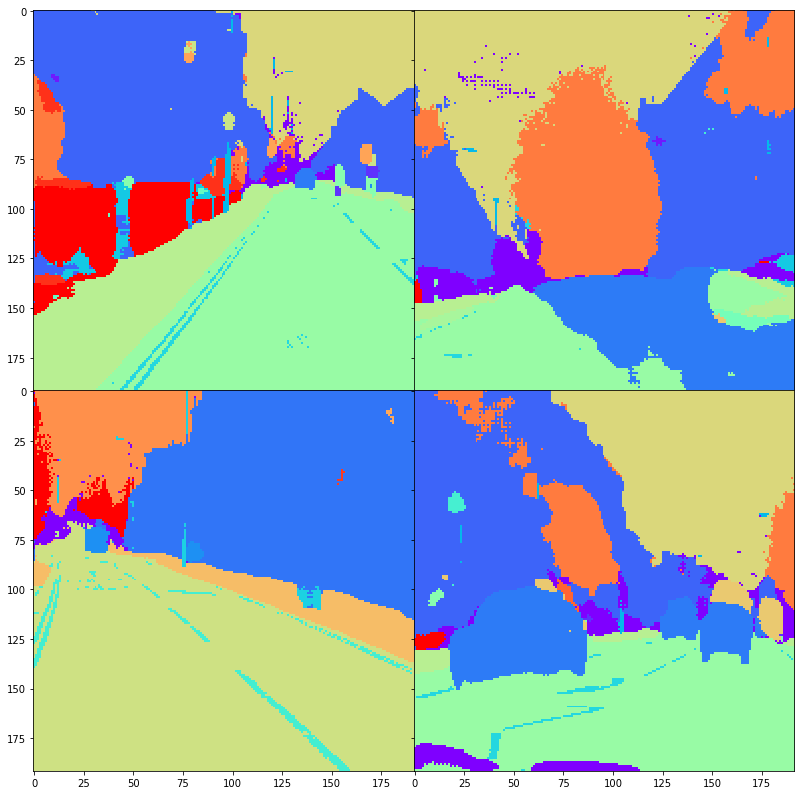

In [143]:
plotGrid(out[0:4].argmax(axis=-1), (14., 14.), cmap='rainbow')

In [144]:
%pdb

Automatic pdb calling has been turned OFF


In [146]:
out1 = model_192.predict(X_trn[0:1, :192, :192])

In [149]:
out1.argmax(axis=-1).shape

(1, 192, 192)

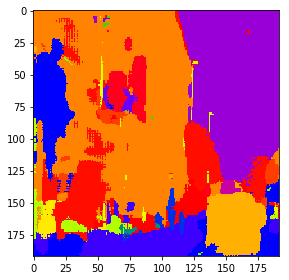

In [152]:
show(out1[0].argmax(axis=-1), do_deprocess=False, cmap='prism')

In [154]:
out2 = model_192.predict(X_trn[0:1, 48:, 128:])

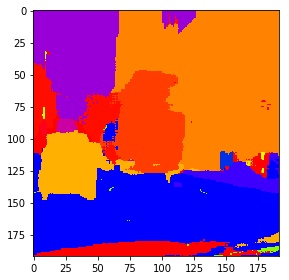

In [155]:
show(out2[0].argmax(axis=-1), do_deprocess=False, cmap='prism')

In [156]:
out3 = model_192.predict(X_trn[100:101, 48:, 128:])

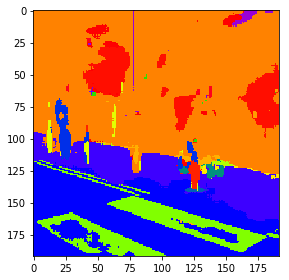

In [157]:
show(out3[0].argmax(axis=-1), do_deprocess=False, cmap='prism')

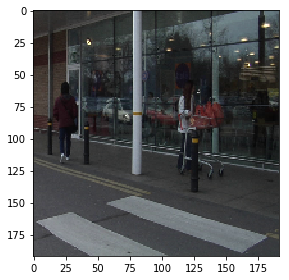

In [158]:
show(X_trn[100, 48:, 128:])

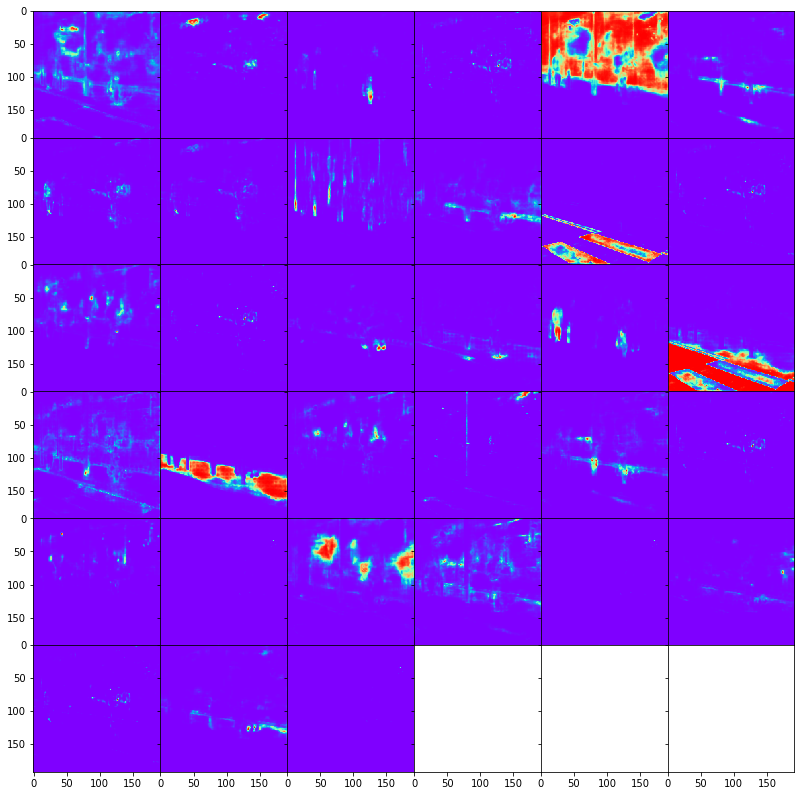

In [162]:
plotGrid(to_plot(out3[0], (192, 192)), (14., 14.), cmap='rainbow')

After all the model isn't as perfect as it first seemed. Maybe it needs more training. However, this time around let's really use the full image.

In [163]:
X_trn.shape

(367, 240, 320, 3)

In [16]:
nb_layers_per_block=[4,5,7,10,12,15]

In [17]:
input_shape = (224, 320)

In [20]:
model_full = Tiramisu(NB_CLASSES, input_shape+(3,), 6, 16, 48, nb_layers_per_block, p=0.1, wd=1e-4)

trans_dn [None, 224, 320, 112]
trans_dn [None, 112, 160, 192]
trans_dn [None, 56, 80, 304]
trans_dn [None, 28, 40, 464]
trans_dn [None, 14, 20, 656]
trans_dn [None, 7, 10, 896]
up_path_before
up_path_transition_up
x: Tensor("add_327:0", shape=(?, ?, ?, 240), dtype=float32)
up_path_before
x: Tensor("concat_162:0", shape=(?, 14, 20, 1088), dtype=float32)
up_path_transition_up
x: Tensor("add_353:0", shape=(?, ?, ?, 192), dtype=float32)
up_path_before
x: Tensor("concat_174:0", shape=(?, 28, 40, 816), dtype=float32)
up_path_transition_up
x: Tensor("add_375:0", shape=(?, ?, ?, 160), dtype=float32)
up_path_before
x: Tensor("concat_183:0", shape=(?, 56, 80, 576), dtype=float32)
up_path_transition_up
x: Tensor("add_391:0", shape=(?, ?, ?, 112), dtype=float32)
up_path_before
x: Tensor("concat_190:0", shape=(?, 112, 160, 384), dtype=float32)
up_path_transition_up
x: Tensor("add_403:0", shape=(?, ?, ?, 80), dtype=float32)


In [21]:
trn_gen_full = segm_generator_hd(X_trn, y_trn_conv, 1, input_shape, train=True)
val_gen_full = segm_generator_hd(X_val, y_val_conv, 1, input_shape, train=False)
test_gen_full = segm_generator_hd(X_test, y_test_conv, 1, input_shape, train=False)

In [22]:
model_full.compile(RMSprop(1e-3), 'sparse_categorical_crossentropy', ['accuracy'])

In [214]:
model_full.fit_generator(trn_gen_full, samples, 1, 2,  
                    validation_data=val_gen_full, nb_val_samples=val_samples, nb_worker=4)

Epoch 1/1
157s - loss: 1.9943 - acc: 0.5371 - val_loss: 1.5624 - val_acc: 0.5612


In [ ]:
model_full.load_weights('./results/2017-05-03-20:45_camvid_tiramisu_192_epoch160.h5')

In [216]:
out_full = model_full.predict(X_trn[100:101, :224, :320])

In [217]:
out_full.shape

(1, 224, 320, 33)

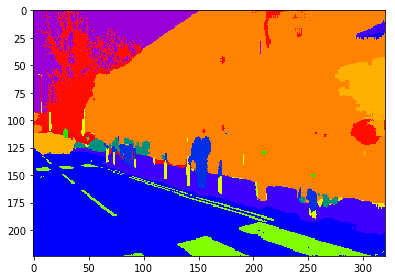

In [218]:
show(out_full[0].argmax(axis=-1), do_deprocess=False, cmap='prism')

In [207]:
len(X_test)

233

In [209]:
model_full.evaluate_generator(test_gen_full, 233, nb_worker=4)

[nan, 0.8684776023733769]

So, loading the weights from the model_192 worked. The structure was the same, only the resolution was different. For FCNs this works - how nice. 

In [221]:
checkpointer = ModelCheckpoint(filepath="./results/"+timestamp()+"_camvid_tiramisu_320_224_full_{epoch:02d}_{val_acc:.2f}.h5", 
                               verbose=0, save_best_only=True, monitor = 'val_acc', period=10)

In [223]:
history_full = model_full.fit_generator(trn_gen_full, samples, 270, 2, callbacks=[checkpointer], 
                    validation_data=val_gen_full, nb_val_samples=val_samples, nb_worker=4)

Epoch 1/270
142s - loss: 0.5627 - acc: 0.8710 - val_loss: 0.5482 - val_acc: 0.8783
Epoch 2/270
142s - loss: 0.5411 - acc: 0.8764 - val_loss: 0.5955 - val_acc: 0.8678
Epoch 3/270
143s - loss: 0.5356 - acc: 0.8771 - val_loss: 0.5441 - val_acc: 0.8782
Epoch 4/270
141s - loss: 0.5276 - acc: 0.8815 - val_loss: 0.5642 - val_acc: 0.8729
Epoch 5/270


KeyboardInterrupt: 

In [224]:
history_full = model_full.fit_generator(trn_gen_full, samples, 100, 2, callbacks=[checkpointer], 
                    validation_data=val_gen_full, nb_val_samples=val_samples, nb_worker=4)

Epoch 1/100
141s - loss: 0.5287 - acc: 0.8793 - val_loss: 0.5501 - val_acc: 0.8776
Epoch 2/100
142s - loss: 0.5190 - acc: 0.8817 - val_loss: 0.5772 - val_acc: 0.8658
Epoch 3/100
142s - loss: 0.5140 - acc: 0.8827 - val_loss: 0.5908 - val_acc: 0.8640
Epoch 4/100
142s - loss: 0.5176 - acc: 0.8823 - val_loss: 0.5495 - val_acc: 0.8755
Epoch 5/100
143s - loss: 0.5176 - acc: 0.8819 - val_loss: 0.5486 - val_acc: 0.8739
Epoch 6/100
355s - loss: 0.5186 - acc: 0.8809 - val_loss: 0.5274 - val_acc: 0.8813
Epoch 7/100
143s - loss: 0.5077 - acc: 0.8849 - val_loss: 0.5453 - val_acc: 0.8751
Epoch 8/100
143s - loss: 0.5144 - acc: 0.8826 - val_loss: 0.5447 - val_acc: 0.8778
Epoch 9/100
144s - loss: 0.5110 - acc: 0.8842 - val_loss: 0.5185 - val_acc: 0.8829
Epoch 10/100
144s - loss: 0.5031 - acc: 0.8858 - val_loss: 0.5790 - val_acc: 0.8661
Epoch 11/100
143s - loss: 0.5086 - acc: 0.8847 - val_loss: 0.5454 - val_acc: 0.8785
Epoch 12/100
143s - loss: 0.5121 - acc: 0.8838 - val_loss: 0.5673 - val_acc: 0.8701
E

In [225]:
model_full.optimizer=keras.optimizers.RMSprop(1e-4)

In [226]:
history_full_1 = model_full.fit_generator(trn_gen_full, samples, 70, 2, callbacks=[checkpointer], 
                    validation_data=val_gen_full, nb_val_samples=val_samples, nb_worker=4)

Epoch 1/70
148s - loss: 0.4679 - acc: 0.8958 - val_loss: 0.5409 - val_acc: 0.8804
Epoch 2/70
141s - loss: 0.4691 - acc: 0.8962 - val_loss: 0.5330 - val_acc: 0.8800
Epoch 3/70
142s - loss: 0.4721 - acc: 0.8944 - val_loss: 0.5349 - val_acc: 0.8802
Epoch 4/70
141s - loss: 0.4708 - acc: 0.8954 - val_loss: 0.5250 - val_acc: 0.8812
Epoch 5/70
142s - loss: 0.4688 - acc: 0.8955 - val_loss: 0.5981 - val_acc: 0.8606
Epoch 6/70
141s - loss: 0.4654 - acc: 0.8964 - val_loss: 0.6751 - val_acc: 0.8442
Epoch 7/70
142s - loss: 0.4707 - acc: 0.8949 - val_loss: 0.5416 - val_acc: 0.8766
Epoch 8/70
142s - loss: 0.4722 - acc: 0.8954 - val_loss: 0.5254 - val_acc: 0.8820
Epoch 9/70
142s - loss: 0.4738 - acc: 0.8943 - val_loss: 0.5342 - val_acc: 0.8820
Epoch 10/70
142s - loss: 0.4640 - acc: 0.8976 - val_loss: 0.5482 - val_acc: 0.8810
Epoch 11/70
142s - loss: 0.4678 - acc: 0.8954 - val_loss: 0.5064 - val_acc: 0.8896
Epoch 12/70
142s - loss: 0.4669 - acc: 0.8957 - val_loss: 0.5051 - val_acc: 0.8869
Epoch 13/70
1

In [227]:
model_full.optimizer=keras.optimizers.RMSprop(1e-5)

In [228]:
history_full_2 = model_full.fit_generator(trn_gen_full, samples, 100, 2, callbacks=[checkpointer], 
                    validation_data=val_gen_full, nb_val_samples=val_samples, nb_worker=4)

Epoch 1/100
148s - loss: 0.4591 - acc: 0.8999 - val_loss: 0.5451 - val_acc: 0.8806
Epoch 2/100
142s - loss: 0.4663 - acc: 0.8976 - val_loss: 0.5518 - val_acc: 0.8723
Epoch 3/100
142s - loss: 0.4592 - acc: 0.8995 - val_loss: 0.5488 - val_acc: 0.8782
Epoch 4/100
142s - loss: 0.4678 - acc: 0.8972 - val_loss: 0.5374 - val_acc: 0.8816
Epoch 5/100
141s - loss: 0.4568 - acc: 0.9008 - val_loss: 0.5618 - val_acc: 0.8759
Epoch 6/100
142s - loss: 0.4650 - acc: 0.8988 - val_loss: 0.5420 - val_acc: 0.8823
Epoch 7/100
142s - loss: 0.4653 - acc: 0.8974 - val_loss: 0.5136 - val_acc: 0.8880
Epoch 8/100
141s - loss: 0.4639 - acc: 0.8990 - val_loss: 0.5165 - val_acc: 0.8860
Epoch 9/100
142s - loss: 0.4595 - acc: 0.8999 - val_loss: 0.5257 - val_acc: 0.8829
Epoch 10/100
142s - loss: 0.4641 - acc: 0.8982 - val_loss: 0.5619 - val_acc: 0.8748
Epoch 11/100
142s - loss: 0.4613 - acc: 0.8993 - val_loss: 0.5077 - val_acc: 0.8906
Epoch 12/100
142s - loss: 0.4593 - acc: 0.8999 - val_loss: 0.5440 - val_acc: 0.8781
E

In [229]:
save_model(model_full, './results///lts/', 'camvid_tiramisu_320_240_full_epoch275')

2017-05-04-10:41
camvid_tiramisu_320_240_full_epoch275
Saved  model  to  disk


In [233]:
cyclr = CyclicLR(5e-4, 1e-5, 3*samples, mode='exp_range')

In [234]:
histroy_full_3 = model_full.fit_generator(trn_gen_full, samples, 200, 2, callbacks=[checkpointer, cyclr], 
                    validation_data=val_gen_full, nb_val_samples=val_samples, nb_worker=4)

Epoch 1/200
145s - loss: 0.4577 - acc: 0.9020 - val_loss: 0.5402 - val_acc: 0.8843
Epoch 2/200
145s - loss: 0.4599 - acc: 0.9015 - val_loss: 0.5309 - val_acc: 0.8853
Epoch 3/200
146s - loss: 0.4618 - acc: 0.9006 - val_loss: 0.5318 - val_acc: 0.8846
Epoch 4/200
146s - loss: 0.4579 - acc: 0.9016 - val_loss: 0.5176 - val_acc: 0.8903
Epoch 5/200
146s - loss: 0.4573 - acc: 0.9022 - val_loss: 0.5633 - val_acc: 0.8800
Epoch 6/200
145s - loss: 0.4608 - acc: 0.9009 - val_loss: 0.5236 - val_acc: 0.8869
Epoch 7/200
146s - loss: 0.4597 - acc: 0.9013 - val_loss: 0.5513 - val_acc: 0.8824
Epoch 8/200
146s - loss: 0.4585 - acc: 0.9014 - val_loss: 0.5943 - val_acc: 0.8715
Epoch 9/200
146s - loss: 0.4630 - acc: 0.9002 - val_loss: 0.5290 - val_acc: 0.8876
Epoch 10/200
146s - loss: 0.4619 - acc: 0.9009 - val_loss: 0.5453 - val_acc: 0.8820
Epoch 11/200
146s - loss: 0.4588 - acc: 0.9014 - val_loss: 0.5159 - val_acc: 0.8874
Epoch 12/200
146s - loss: 0.4615 - acc: 0.9007 - val_loss: 0.5366 - val_acc: 0.8828
E

KeyboardInterrupt: 

In [236]:
save_model(model_full, './results/', 'camvid_tiramisu_320_240_full_epoch369')

2017-05-04-20:27
camvid_tiramisu_320_240_full_epoch369
Saved  model  to  disk


I summarize what I have learned so far:
* Size matters. Too small crops only produce low accuracies - context.
* A matrix output and target learns faster than an unrolled vector - context again. Do it by ```Rehape, Activation, Reshape``` or by using ```hidim_softmax()```.  
* When using rectangular aspect ratios both dimensions must be sums of powers of 2, e.g. 224, 256, ..., else at the bottleneck there are round-off errors

In [237]:
def iou(y_true, y_preds):
    ''' Returns intersection over union used as segmentation performance metric
    :param y_true: target mask of shape (observation, linearized_pic, classes)
    :param y_preds: model predictions of same shape as y_true
    :returns: 1-D array of IoU ratios per class 
    '''
    assert y_true.shape == y_preds.shape
    s = y_true.shape
    y_true = y_true.reshape(s[0]*s[1], s[2])
    y_preds = y_preds.reshape(s[0]*s[1], s[2])
    preds_true = np.stack(list(zip(y_preds, y_true)))
    numerator = np.sum(np.all(preds_true, axis=1), axis=0)
    denominator = np.sum(np.any(preds_true, axis=1), axis=0)
    return numerator/denominator

In [240]:
out = model_full.predict(X_trn[100:101, :224, :])

In [241]:
out.shape

(1, 224, 320, 33)

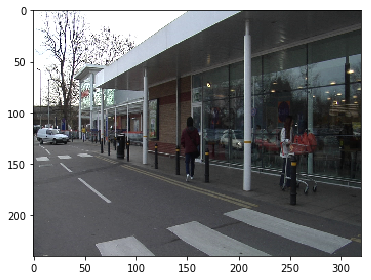

In [245]:
show(X_trn[100], do_deprocess=True, cmap='prism')

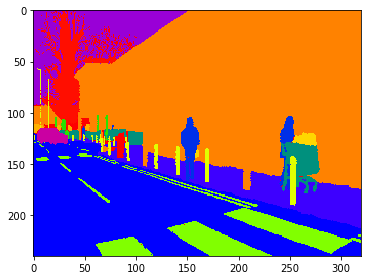

In [246]:
show(y_trn_conv[100], do_deprocess=False, cmap='prism')

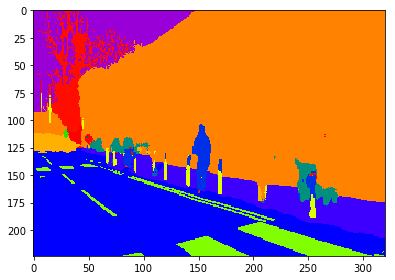

In [243]:
show(out[0].argmax(axis=-1), do_deprocess=False, cmap='prism')

The model is mostly right and does an amazing job on the tree (high contrast). It mostly makes errors where objects are eclipsed (e.g. lady with shopping cart and pole) or low contrast (car in the background).

Now for two completely unrelated street scenes which aren't even in the CamVid data set. The first one kind of resembles the training data:

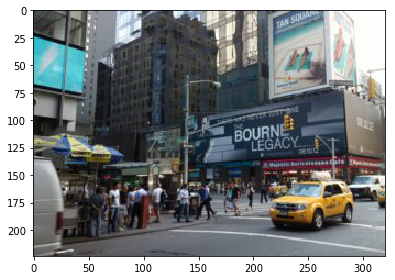

In [259]:
street_scene = img_to_array(Image.open('./Street-scene-320_224.jpg')); show(street_scene, do_deprocess=False)

In [260]:
street_scene.shape

(224, 320, 3)

In [262]:
street_scene = np.expand_dims(street_scene/255., axis=0)

In [263]:
sc = model_full.predict(street_scene)

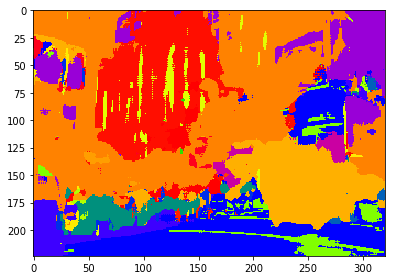

In [267]:
show(sc[0].argmax(axis=-1), do_deprocess=False, cmap='prism')

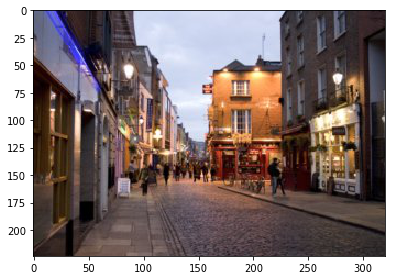

In [268]:
high_street = img_to_array(Image.open('./high-street-scene-320_224.jpg')); show(high_street, do_deprocess=False)

In [269]:
high_street = np.expand_dims(high_street/255., axis=0)

In [270]:
hs = model_full.predict(high_street)

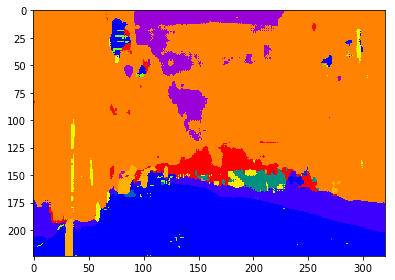

In [271]:
show(hs[0].argmax(axis=-1), do_deprocess=False, cmap='prism')

Both ex data examples aren't that great. Well, Camvid doesn't cover such a large range of different scense. Perhaps mean subtraction before training might help after all?

In [276]:
model_full.evaluate_generator(test_gen_full, len(X_test), nb_worker=4)

[nan, 0.89024478197097778]